In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt 

import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm 

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transform)

In [4]:

X_train = trainset.data.float()
y_train = trainset.targets.float()

X_test = testset.data.float()
y_test = testset.targets.float()



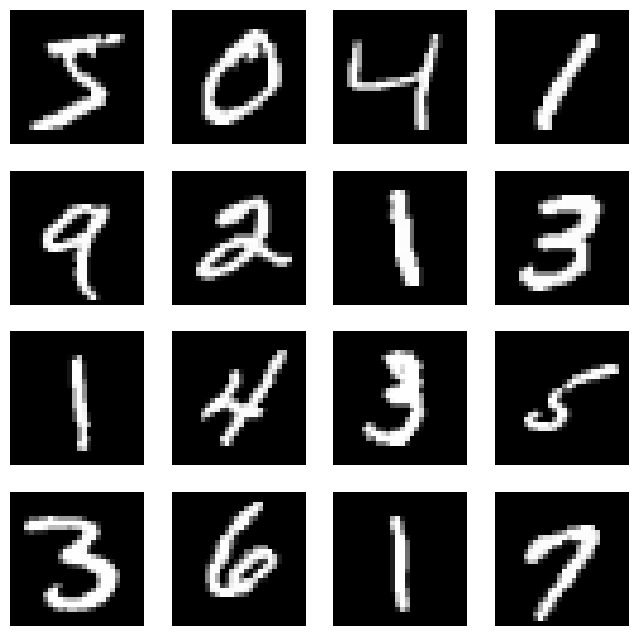

In [6]:
#Lets Check to see what the data looks like 

fig, axs = plt.subplots(4,4, figsize = (8,8))
for inx, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[inx, :, :], cmap = 'gray')
    ax.axis('off')


    

In [7]:
# We need to know the shape of our inputs!

print(X_train[0,:,:].shape)

torch.Size([28, 28])


In [6]:
# Now let's define our network 

Width = 5
Depth = 100
Input_Dimensions = (28, 28)

# Activation Function: ReLU

class DNN(nn.Module):
    def __init__(self, Width, Depth, input_dimensions) -> None:
        super().__init__()
        
        self.input_dims = input_dimensions
        
        self.input_layer = nn.Linear(input_dimensions[0] * input_dimensions[1], Depth)
        self.hidden_layer01 = nn.Linear(Depth, Depth)
        self.hidden_layer02 = nn.Linear(Depth, Depth)
        self.hidden_layer03 = nn.Linear(Depth, Depth)
        self.output_layer   = nn.Linear(Depth, 10)
        
        self.relu = nn.ReLU()
        self.output_activation = nn.LogSoftmax(dim = 0)
        
    def forward(self, img): 
        x = img.view(-1, self.input_dims[0] * self.input_dims[1])
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer01(x))
        x = self.relu(self.hidden_layer02(x))
        x = self.relu(self.hidden_layer03(x))
        x = self.output_layer(x)
        return x
            
            
f = DNN(Width, Depth, Input_Dimensions)





In [7]:
# Plot the Networks initial Guesses

guesses = []
for i in range(8):
    guesses.append(torch.argmax(f(X_train[i, :,:])))
    print('the network guessed that the {}th image was: {}, the correct answer is: {}'.format(i, guesses[i], y_train[i]))

    
guesses = torch.FloatTensor(guesses)
print('accuracy = {} %'.format((guesses == y_train[0:8]).sum() / len(guesses) )) 



the network guessed that the 0th image was: 5, the correct answer is: 5.0
the network guessed that the 1th image was: 5, the correct answer is: 0.0
the network guessed that the 2th image was: 5, the correct answer is: 4.0
the network guessed that the 3th image was: 5, the correct answer is: 1.0
the network guessed that the 4th image was: 5, the correct answer is: 9.0
the network guessed that the 5th image was: 5, the correct answer is: 2.0
the network guessed that the 6th image was: 5, the correct answer is: 1.0
the network guessed that the 7th image was: 5, the correct answer is: 3.0
accuracy = 0.125 %


In [8]:
# Let's train the model
# Because the dataset is 60,000 images, we shall just train on a small subset (256 examples) of the data for each iteration
# if we had a more powerful computer than my laptop, this wouldn't be necessary.

from tqdm.notebook import tqdm

batch_size = 64
N_epochs = 10
optimizer = optim.Adam(f.parameters(), lr = 1e-3 )
lfn = nn.CrossEntropyLoss()

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

loss_list = []


for epoch in tqdm(range(N_epochs), desc = 'training neural network'):
    for images, labels in trainloader:
        optimizer.zero_grad()
        pred_labels = f(images)
        loss = lfn(pred_labels, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss)


training neural network:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# Let's check the accuracy now 
N_examples = 250

guesses = []
for i in range(N_examples):
    guesses.append(torch.argmax(f(X_test[i, :,:])))
    #print('the network guessed that the {}th image was: {}, the correct answer is: {}'.format(i, guesses[i], y_test[i]))
    
guesses = torch.FloatTensor(guesses)
print('accuracy over {} random test samples = {} %'.format(N_examples, (guesses == y_test[0:N_examples]).sum() / len(guesses) )) 

# 96 %, pretty good ! 

accuracy over 250 random test samples = 0.9679999947547913 %


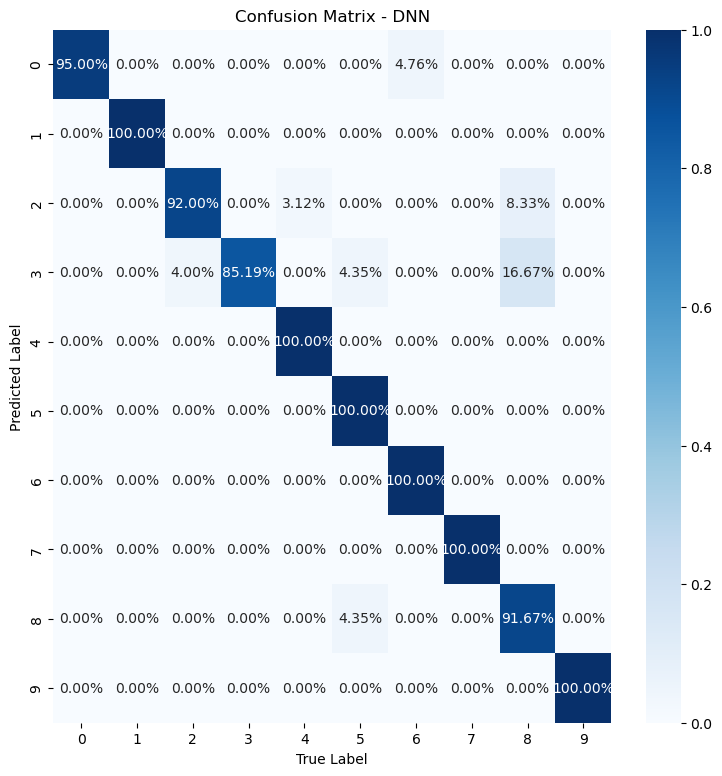

In [11]:
# Let's plot a confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import numpy as np 

cm = confusion_matrix(guesses, y_test[0:N_examples])


fig, ax = plt.subplots(figsize = (9,9))


sns.heatmap(cm/np.sum(cm, axis = 1), annot=True, 
            fmt='.2%', cmap='Blues', ax = ax)

ax.set_title('Confusion Matrix - DNN')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')


plt.savefig(r'/Users/jacobblum/Desktop/cv_tex/figs/DNN_cm.png')
